# Assignment 5 - Testing

### Step 1 - Data Import

Shape of input data: (29492, 1, 14, 14)
shape = (num_samples, num_channels, image_height, image_width)


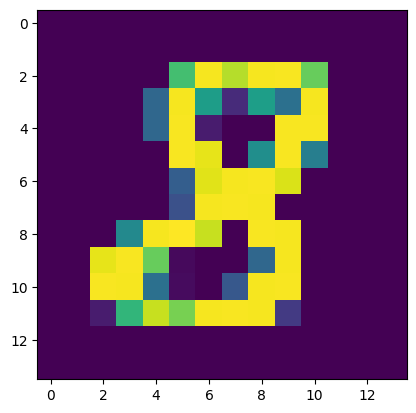

In [267]:
import numpy as np
import os
import matplotlib.pyplot as plt

cwd = os.getcwd()
ass_dir = cwd.rsplit('\\', maxsplit=1)[0]

raw_data = np.loadtxt(os.path.join(ass_dir, r'data\even_mnist.csv'), dtype=str)

# separate label from images
input = raw_data[:, :-1].astype(float)/255
label = raw_data[:, -1:].astype(float)

# reshape the flattened images into 2D
input = input.reshape((len(label), 1, 14, 14))
print("Shape of input data:", input.shape)
print("shape = (num_samples, num_channels, image_height, image_width)")

# take a look at a digit
plt.style.use('default')
plt.imshow(input[2001][0])
plt.show()

### Step 1.5 - Figure out sizes for convolutions

In [268]:
import torch
import torch.nn as nn

ex_input = torch.randn(1, 14, 14)
conv = nn.Conv2d(1, 7, 3, padding=1, stride=2)
conv2 = nn.Conv2d(7, 14, 3, padding=0, stride=2)
deconv1 = nn.ConvTranspose2d(14, 7, 3, stride=2, output_padding=0)
deconv2 = nn.ConvTranspose2d(7, 1, 3, padding=1, stride=2, output_padding=1)

step1 = conv(ex_input)
step2 = conv2(step1)
step3 = deconv1(step2)
step4 = deconv2(step3)


print("input:", ex_input.shape)
print("conv1:", step1.shape)
print("conv2: ", step2.shape)
print("deconv1:", step3.shape)
print("deconv2:", step4.shape)

input: torch.Size([1, 14, 14])
conv1: torch.Size([7, 7, 7])
conv2:  torch.Size([14, 3, 3])
deconv1: torch.Size([7, 7, 7])
deconv2: torch.Size([1, 14, 14])


### Step 2 - Setup Encoder Portion

In [269]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define latent size for tuning purposes
latent_size = 20
kernal_size = 3

class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.con_layer1 = nn.Conv2d(1, 7, kernal_size, padding=1, stride=2) # we only have one input channel (i.e. non-RGB)
        self.batch = nn.BatchNorm2d(7)
        self.con_layer2 = nn.Conv2d(7, 14, kernal_size, padding=0, stride=2)
        self.lin1 = nn.Linear(3*3*14, 49) # 14 channels of 3x3 after convolutions
        self.lin_mu = nn.Linear(49, latent_size) # layer for mu
        self.lin_sigma = nn.Linear(49, latent_size) # layer for sigma

        # initialize KL for now
        self.kl = 0

        # setting up the normal distribution generator
        self.normal = torch.distributions.normal.Normal(torch.tensor([0.0]).to("cuda"), torch.tensor([1.0]).to("cuda"))

    def forward(self, x):
        # first convolution layer
        x = self.con_layer1(x)
        x = F.relu(x)

        # batch layer
        x = self.batch(x)
        x = F.relu(x)

        # second convolution layer
        x = self.con_layer2(x)
        x = F.relu(x)

        # flatten and send to lienar layers
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(x)
        x = F.relu(x)

        # separate layers for mu and sigma
        mu = self.lin_mu(x)
        log_sigma = self.lin_sigma(x)
        sigma = torch.exp(log_sigma)

        # generate samples from normal distribution
        sample = self.normal.sample(mu.shape)
        sample = torch.reshape(sample, (sample.shape[0], 20))

        # print("mu shape:", mu.shape)
        # print("log_sigma shape:", log_sigma.shape)
        # print("sigma shape:", sigma.shape)
        # print("sample shape:", sample.shape)
        # combine sigma and mu to produce z
        z = sigma*sample + mu
        
        # KL metric
        self.kl = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - sigma.pow(2))

        return z

### Step 3 - Setup Decoder Portion

In [270]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # reverse the encoder basically

        # linear portion
        self.lin1 = nn.Linear(latent_size, 49)
        self.lin2 = nn.Linear(49, 3*3*14)

        # reshape to 2D
        self.reshape2D = nn.Unflatten(dim=1, unflattened_size=(14, 3, 3)) # unflatten to 14 channels of 3x3

        # convolutional portion
        self.deconv1 = nn.ConvTranspose2d(14, 7, 3, stride=2, output_padding=0)
        self.batch = nn.BatchNorm2d(7)
        self.deconv2 = nn.ConvTranspose2d(7, 1, 3, padding=1, stride=2, output_padding=1)


    def forward(self, z):
        # linear portion of decoding - mirrors encoding
        z = self.lin1(z)
        z = F.relu(z)

        z = self.lin2(z)
        z = F.relu(z)

        # reshape things for convolution
        z = self.reshape2D(z)

        # convolution in reverse
        z = self.deconv1(z)
        z = self.batch(z)
        z = F.relu(z)
        z = self.deconv2(z)

        # output needs to be greater than 1 so use sigmoid
        z = torch.sigmoid(z)

        return z

### Step 4 - Combine Encoder and Decoder into VAE

In [271]:
class VAE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        z = self.enc.forward(x)
        output = self.dec.forward(z)
        return output

### Step 5 - Test Model Goes Forward

output shape: (10, 1, 14, 14)


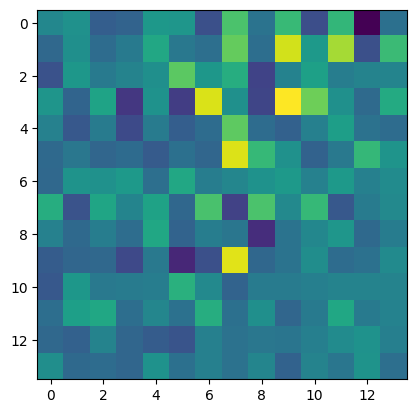

In [272]:
torch.manual_seed(1234)

vae_model = VAE().to('cuda')
input = torch.from_numpy(input).type(torch.float).to('cuda')
label = torch.from_numpy(label).type(torch.float).to('cuda')

output = vae_model.forward(input[0:10])
output_np = output.detach().cpu().numpy()
print("output shape:", output_np.shape)
plt.imshow(output_np[0][0])
plt.show()

### Step 6 - Setup Data Loaders

In [273]:
batch_size = 200

input_set = torch.utils.data.TensorDataset(input, label)
input_loader = torch.utils.data.DataLoader(input_set, batch_size=batch_size, shuffle=True)

### Step 7 - Train Model

In [274]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 300
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

# bce = nn.BCELoss(reduction='sum')
obj_vals = []

for epoch in range(num_epochs):
    loss_sum = 0
    for (inputs, _) in input_loader:
        loss = torch.sum((inputs - vae_model.forward(inputs)).pow(2)) + vae_model.enc.kl # using MSE loss & KL
        loss_sum += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    obj_val = loss_sum/len(input_loader.dataset)
    obj_vals.append(obj_val)

    if (epoch+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}: \t Loss: {obj_val:.2f}')

print(f"Final Loss: \t {obj_val:.2f}")

Epoch 5/300: 	 Loss: 12.67
Epoch 10/300: 	 Loss: 9.98
Epoch 15/300: 	 Loss: 9.40
Epoch 20/300: 	 Loss: 9.14
Epoch 25/300: 	 Loss: 9.03
Epoch 30/300: 	 Loss: 8.93
Epoch 35/300: 	 Loss: 8.88
Epoch 40/300: 	 Loss: 8.81
Epoch 45/300: 	 Loss: 8.78
Epoch 50/300: 	 Loss: 8.73
Epoch 55/300: 	 Loss: 8.71
Epoch 60/300: 	 Loss: 8.67
Epoch 65/300: 	 Loss: 8.63
Epoch 70/300: 	 Loss: 8.63
Epoch 75/300: 	 Loss: 8.61
Epoch 80/300: 	 Loss: 8.60
Epoch 85/300: 	 Loss: 8.56
Epoch 90/300: 	 Loss: 8.56
Epoch 95/300: 	 Loss: 8.56
Epoch 100/300: 	 Loss: 8.54
Epoch 105/300: 	 Loss: 8.53
Epoch 110/300: 	 Loss: 8.52
Epoch 115/300: 	 Loss: 8.52
Epoch 120/300: 	 Loss: 8.52
Epoch 125/300: 	 Loss: 8.50
Epoch 130/300: 	 Loss: 8.50
Epoch 135/300: 	 Loss: 8.50
Epoch 140/300: 	 Loss: 8.49
Epoch 145/300: 	 Loss: 8.48
Epoch 150/300: 	 Loss: 8.47
Epoch 155/300: 	 Loss: 8.46
Epoch 160/300: 	 Loss: 8.48
Epoch 165/300: 	 Loss: 8.47
Epoch 170/300: 	 Loss: 8.46
Epoch 175/300: 	 Loss: 8.46
Epoch 180/300: 	 Loss: 8.44
Epoch 185/3

### Step 8 - Generate digit sample images with trained model

output shape: (10, 1, 14, 14)


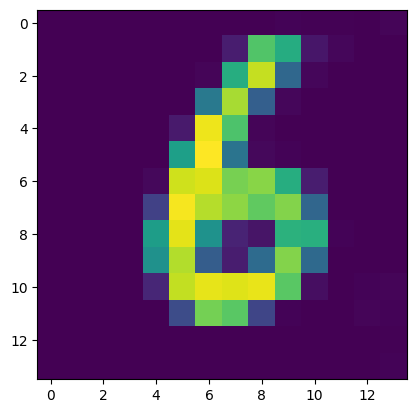

In [283]:
output = vae_model.forward(input[0:10])
output_np = output.detach().cpu().numpy()
print("output shape:", output_np.shape)
plt.imshow(output_np[7][0])
plt.show()

Original

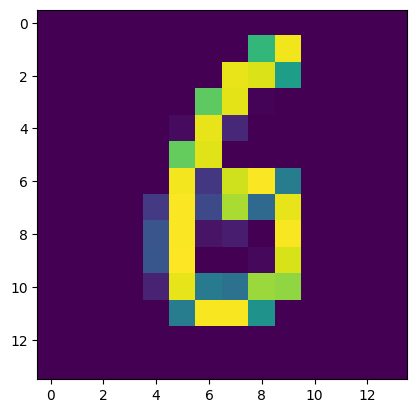

In [284]:
plt.imshow(input.detach().cpu().numpy()[7][0])
plt.show()